# Triple Star Search
### First notebook - identify possible interactions
This notebook sums up all of the steps I took to find the indices of any stars that may have passed within one arcsecond of one another with trajectories traced by their proper motions over a timescale of one million years.

The overall procedure is:
* Open .fits file of Gaia data from Orion (this could be made more efficient).
* Use HR diagram cuts to filter, isolate young stars.
* Project all applicable stars back by timesteps of 100 years, retaining the indices when stars pass withiin one arcsecond of one another.
* Write indices and timesteps of retained data to a .npz file, which is picked up in following work.

The process of identifying matched pairs for the large sample size and number of timesteps we use is time-intensive, and since the .npz file this notebook writes is included, there should be no reason to run this file.

In [2]:
from astropy.io import fits
from astropy.table import Table, QTable
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import sqrt, log10

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
#Open the appropriate fits file, extract relevant data, close file
hdul = fits.open('c:\\users\\sahal\\2018TrinaryWork\\gaiadr2_OrionTables.fits')
pmra_all = hdul[1].data['pmra'] / 3600000 #pmra is in mas/yr - converts to deg/yr
pmdec_all = hdul[1].data['pmdec'] / 3600000 #pmdec is in mas/yr - converts to deg/yr
radial_velocity_all = hdul[1].data['radial_velocity'] #radial velocity is in mas/yr? or parsec/yr?
source_id_all = hdul[1].data['source_id']
ra_all = hdul[1].data['ra'] #ra in deg
dec_all = hdul[1].data['dec'] #dec in deg
parallax_all = hdul[1].data['parallax'] #parallax in mas

G_all = hdul[1].data['phot_g_mean_mag'] #magnitudes in G filter
Gb_all = hdul[1].data['phot_bp_mean_mag']#magnitudes in Gbp filter
Gr_all = hdul[1].data['phot_rp_mean_mag']#magnitudes in Brp filter

bp_rp_all = hdul[1].data['bp_rp']#color difference b-r
#This is the same as subtracting Gb - Gr

ra_err_all = hdul[1].data['ra_error']
dec_err_all = hdul[1].data['dec_error']
pmra_err_all = hdul[1].data['pmra_error']
pmdec_err_all = hdul[1].data['pmdec_error']

hdul.close()

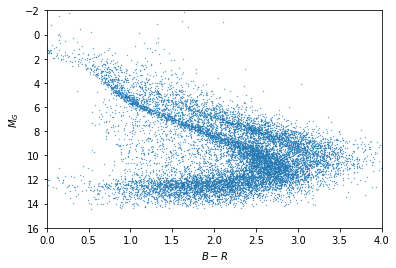

In [6]:
#Absolute magnitude in terms of G and p
Mg_all = [G + 5 - 5*(log10(1000/p)) for G, p in zip(G_all, parallax_all)]
#p is in mas so we divide the listed 1000 by 10

plt.plot(bp_rp_all, Mg_all, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(16,-2)
plt.xlabel("$B - R$")
plt.ylabel("$M_G$")
plt.show()

In [5]:
#Get the indices ii of all values for stars that satisfy appropriate photometric conditions
ii = []

for i in range(len(source_id_all)):
    if( (Mg_all[i]<2.46*(bp_rp_all[i])+2.76 and .3<(bp_rp_all[i])<1.8)
       or (Mg_all[i]<2.8*(bp_rp_all[i])+2.16 and 1.8<(bp_rp_all[i]))):
       #or (Mg_all[i]>2.14*(bp_rp_all[i])-.57 and .5<(bp_rp_all[i])<1.2)
       #or (Mg_all[i]>1.11*(bp_rp_all[i])+.66 and 1.2<(bp_rp_all[i])<3)):
        ii.append(i)
        
print(len(ii))

4022


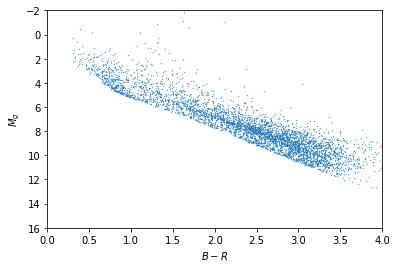

In [8]:
#Redefine our data as all stars that fit photometric parameters of young stars
pmra = pmra_all[ii]
pmdec = pmdec_all[ii]
radial_velocity = radial_velocity_all[ii]
source_id = source_id_all[ii]
ra = ra_all[ii]
dec = dec_all[ii]
parallax = parallax_all[ii]

G = G_all[ii]
Gb = Gb_all[ii]
Gr = Gr_all[ii]

bp_rp = bp_rp_all[ii]

ra_err = ra_err_all[ii]
dec_err = dec_err_all[ii]
pmra_err = pmra_err_all[ii]
pmdec_err = pmdec_err_all[ii]

#############################

Mg = [G + 5 - 5 * log10(1000/p) for G, p in zip(G, parallax)]

plt.plot(bp_rp, Mg, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(16,-2)
plt.xlabel("$B - R$")
plt.ylabel("$M_g$")
plt.show()

In [7]:
def toffset(pmra, pmdec, dt):
    return (pmra * dt, pmdec * dt)

def dist(ra, dec):
    return np.array([np.sqrt( (ra[i]-ra)**2 +  (dec[i]-dec)**2 ) for i in range(len(ra))])

arcsec = 1 / 3600
def updated(ra_in, dec_in, pmra_in, pmdec_in, tstep):
    pmraProj, pmdecProj = toffset(pmra_in, pmdec_in, tstep)
    ra_t = ra_in + pmraProj
    dec_t = dec_in + pmdecProj
    
    alldists = dist(ra_t,dec_t)
    
    successfulMatch = np.where((alldists < arcsec) & (alldists != 0.))
    
    return [tstep,successfulMatch[0]]    


In [26]:
allMatches = []
for t in range(-1000000,100,100):
    val = updated(ra, dec, pmra, pmdec, t)
    #print(vals)
    print(val[0], val[1])
    if val[1].size > 0:
        allMatches.append(val)

#After several attempts at trying to save data to files via astropy tables, I've concluded 
#the best way to go is with numpy's .npz

fnam = 'timecoords.npz'

a = np.array([allMatches[i][0] for i in range(len(allMatches))])
b = np.array([allMatches[i][1] for i in range(len(allMatches))])

np.savez(fnam, time = a, ind = b)

-1000000 []
-999900 []
-999800 []
-999700 []
-999600 []
-999500 []
-999400 []
-999300 []
-999200 []
-999100 []
-999000 []
-998900 []
-998800 []
-998700 []
-998600 []
-998500 []
-998400 []
-998300 []
-998200 []
-998100 []
-998000 []
-997900 []
-997800 []
-997700 []
-997600 []
-997500 []
-997400 []
-997300 []
-997200 []
-997100 []
-997000 []
-996900 []
-996800 []
-996700 []
-996600 []
-996500 []
-996400 []
-996300 []
-996200 []
-996100 []
-996000 []
-995900 []
-995800 []
-995700 []
-995600 []
-995500 []
-995400 []
-995300 []
-995200 []
-995100 []
-995000 []
-994900 []
-994800 []
-994700 []
-994600 []
-994500 []
-994400 []
-994300 []
-994200 []
-994100 []
-994000 []
-993900 []
-993800 []
-993700 []
-993600 []
-993500 []
-993400 []
-993300 []
-993200 []
-993100 []
-993000 []
-992900 []
-992800 []
-992700 []
-992600 []
-992500 []
-992400 []
-992300 []
-992200 []
-992100 []
-992000 []
-991900 []
-991800 []
-991700 []
-991600 []
-991500 []
-991400 []
-991300 []
-991200 []
-991100 []
-991000 [

In [27]:
inVals = np.load(fnam) #has entries ['time'] and ['ind']

In [28]:
tts = inVals['time']
iind = inVals['ind']

tts = np.flip(tts,0)
iind = np.flip(iind,0)


ta = Table([tts, np.array(iind)], names = ('times', 'inds'), meta = {'name': 'IndTable'})
tts = ta['times']
iinds = ta['inds']
print(ta)

 times                inds             
------- -------------------------------
      0                       [604 608]
   -100                       [604 608]
   -200                       [604 608]
   -300                       [604 608]
   -400                       [604 608]
   -500           [ 604  608 3965 3966]
   -600           [ 604  608 3965 3966]
   -700           [ 604  608 3965 3966]
   -800           [ 604  608 3965 3966]
   -900 [ 604  608 3173 3201 3965 3966]
    ...                             ...
-978400                     [2911 3281]
-978500                     [2911 3281]
-978600                     [2911 3281]
-978700                     [2911 3281]
-978800                     [2911 3281]
-978900                     [2911 3281]
-983500                     [3383 3568]
-983600                     [3383 3568]
-983700                     [3383 3568]
-983800                     [3383 3568]
-983900                     [3383 3568]
Length = 2477 rows
